# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 27 января 23:59

**Продуктивной и интересной вам работы!**


In [1]:
%%capture
!pip install optuna
!pip install lime
!pip install shap
!pip install psycopg2-binary
!pip install ucimlrepo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [3]:
def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feat_arr = np.unique(feature_vector)
    if len(feat_arr) == 1:
        return np.array([]), np.array([]), None, -float('inf')
    feat_arr.sort()

    feat_means = (feat_arr.reshape((-1, 1)) + feat_arr.reshape((1, -1))) / 2
    x_axis = np.arange(0, feat_arr.shape[0] - 1)
    y_axis = x_axis + 1

    thresholds = feat_means[x_axis, y_axis]

    masks = feature_vector.reshape((1,-1)) < thresholds.reshape((-1,1))

    target_matrix = np.repeat(target_vector.reshape((1,-1)), masks.shape[0], axis=0)

    left = np.where(masks, target_matrix, -1)
    left_total = (left >= 0).sum(axis=1)
    left_zeros_p = (left==0).sum(axis=1) / left_total
    left_ones_p = (left==1).sum(axis=1) / left_total
    left_val = (1 - left_zeros_p**2 - left_ones_p**2) * left_total / left.shape[1]

    right = np.where(~masks, target_matrix, -1)
    right_total = (right >= 0).sum(axis=1)
    right_zeros_p = (right==0).sum(axis=1) / right_total
    right_ones_p = (right==1).sum(axis=1) / right_total
    right_val = (1 - right_zeros_p**2 - right_ones_p**2) * right_total / right.shape[1]

    ginis = - left_val - right_val

    best_idx = ginis.argmax()

    return thresholds, ginis, thresholds[best_idx], ginis[best_idx]

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [4]:
from matplotlib import pyplot as plt

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/AnastasiyaMax/MLDS_ml_course_fall21/refs/heads/main/hw/hw5_trees/students.csv')

Text(0.5, 1.0, 'Value of Gini Coefficient by Threshold')

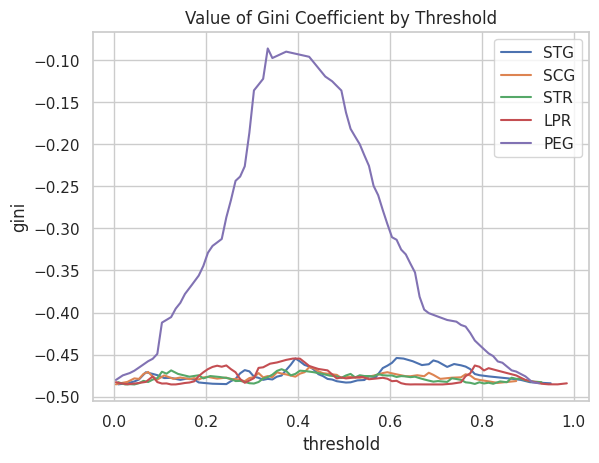

In [6]:
features = df.columns[:-1]

plt.figure()
target = df.UNS.to_numpy()
for feature in features:
  thresholds, ginis, _, _ = find_best_split(df[feature].to_numpy(), target)
  plt.plot(thresholds, ginis, label=feature)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('gini')
plt.title('Value of Gini Coefficient by Threshold')

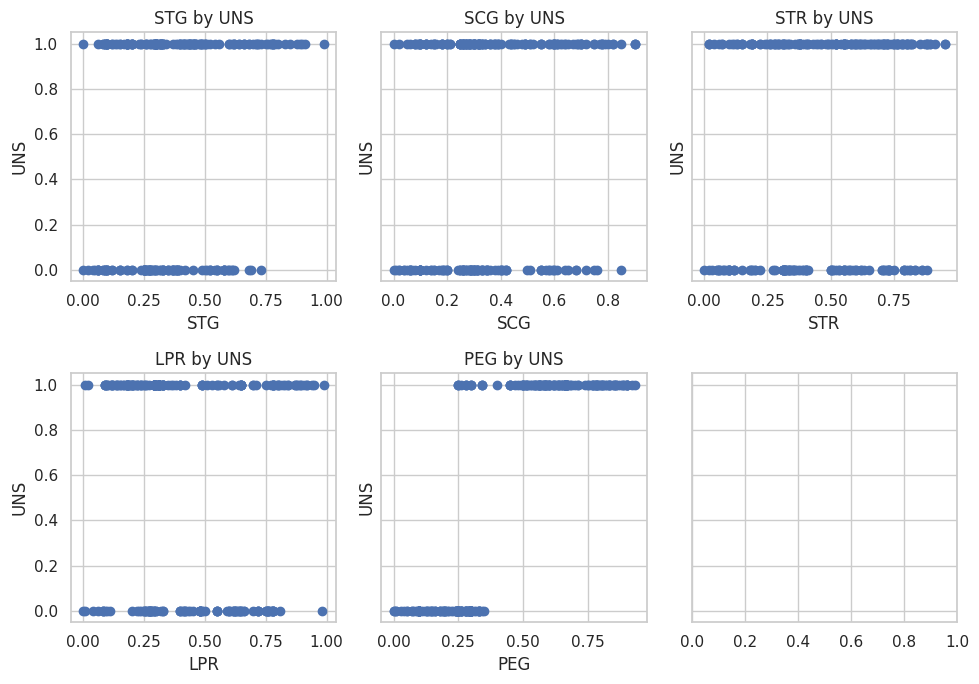

In [7]:
fig, plots = plt.subplots(2, 3, sharey=True, figsize=(10,7))
for i, feature in enumerate(features):
  plots[i//3][i%3].scatter(df[feature], target)
  plots[i//3][i%3].set_title(f'{feature} by UNS')
  plots[i//3][i%3].set_xlabel(feature)
  plots[i//3][i%3].set_ylabel('UNS')
fig.tight_layout()

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**
- по PEG, так как для него существует порог, для которого значение критерия Джини заметно превышает значения для других признаков
- да, так как на графике видно, что целевая переменная практически линейно разделима по данному признаку
- она имеет вид горба или колокола (можно провести аналогию с графиком нормального распределения)
- для признаков, по которым не удается разделить выборку, кривая приближается к горизонтальной прямой

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


In [8]:
from collections import Counter


class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        root_zeros_p = (sub_y==0).sum() / sub_y.shape[0]
        root_ones_p = (sub_y==1).sum() / sub_y.shape[0]
        gini_root = - (1 - root_ones_p**2 - root_zeros_p**2)

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if (gini_best is None or gini > gini_best) and gini > gini_root:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]


        if self._feature_types[node['feature_split']] == 'real':
            next_node = node['left_child'] if x[node['feature_split']] < node['threshold'] else node['right_child']
        elif self._feature_types[node['feature_split']] == 'categorical':
            next_node = node['left_child'] if x[node['feature_split']] in node["categories_split"] else node['right_child']
        else:
            raise ValueError

        if next_node["type"] == "terminal":
            return next_node["class"]
        elif next_node["type"] == "nonterminal":
            return self._predict_node(x, next_node)
        else:
            raise ValueError

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

    def get_params(self, deep=False):
        return {
            'feature_types': self._feature_types,
            'max_depth': self._max_depth,
            'min_samples_split': self._min_samples_split,
            'min_samples_leaf': self._min_samples_leaf
        }

### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [9]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

In [10]:
from sklearn.preprocessing import LabelEncoder

encoders = {}

for feature in X.columns:
    encoders[feature] = LabelEncoder()
    X[feature] = encoders[feature].fit_transform(X[feature])

encoders['poisonous'] = LabelEncoder()
y['poisonous'] = encoders['poisonous'].fit_transform(y['poisonous'])

In [11]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.5, random_state=42)
tree = DecisionTree(['categorical'] * X.shape[1])
tree.fit(Xtr.to_numpy(), ytr.poisonous.to_numpy())
pred = tree.predict(Xte.to_numpy())

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(yte, pred)

1.0

In [13]:
tree._tree

{'type': 'nonterminal',
 'feature_split': 4,
 'categories_split': [3, 0, 5],
 'left_child': {'type': 'nonterminal',
  'feature_split': 19,
  'categories_split': [3, 2, 4, 1, 0, 6, 8, 7],
  'left_child': {'type': 'nonterminal',
   'feature_split': 14,
   'categories_split': [3, 6, 5, 2, 7, 4],
   'left_child': {'type': 'nonterminal',
    'feature_split': 0,
    'categories_split': [4, 5, 2, 0, 3],
    'left_child': {'type': 'nonterminal',
     'feature_split': 1,
     'categories_split': [2, 3, 0],
     'left_child': {'type': 'nonterminal',
      'feature_split': 14,
      'categories_split': [3, 6, 5, 2, 7],
      'left_child': {'type': 'nonterminal',
       'feature_split': 21,
       'categories_split': [0, 6, 1, 4, 3, 5],
       'left_child': {'type': 'terminal', 'class': 0},
       'right_child': {'type': 'nonterminal',
        'feature_split': 1,
        'categories_split': [2],
        'left_child': {'type': 'terminal', 'class': 0},
        'right_child': {'type': 'terminal', 'cl

### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

In [15]:
def label_encode_X(X):
  for feature in X.columns:
      X[feature] = LabelEncoder().fit_transform(X[feature])
  return X

In [16]:
datasets = {
    'mushrooms': fetch_ucirepo(id=73).data,
    'tic-tac-toe': fetch_ucirepo(id=101).data,
    'cars': fetch_ucirepo(id=19).data,
    'nursery': fetch_ucirepo(id=76).data
}

datasets_preprocessed = {
    'mushrooms': {
        'X': label_encode_X(datasets['mushrooms'].features),
        'y': datasets['mushrooms'].targets['poisonous'].apply(lambda x: 1 if x == 'p' else 0)
    },
    'tic-tac-toe': {
        'X': label_encode_X(datasets['tic-tac-toe'].features),
        'y': datasets['tic-tac-toe'].targets['class'].apply(lambda x: 1 if x == 'positive' else 0)
    },
    'cars': {
        'X': label_encode_X(datasets['cars'].features),
        'y': datasets['cars'].targets['class'].apply(lambda x: 1 if x in ('good', 'vgood') else 0)
    },
    'nursery': {
        'X': label_encode_X(datasets['nursery'].features),
        'y': datasets['nursery'].targets['class'].apply(lambda x: 1 if x in ('very_recom', 'priority', 'spec_prior') else 0)
    }
}

In [17]:
datasets_res = {}

for name, dataset in datasets_preprocessed.items():
    datasets_res[name] = {}

    datasets_res[name]['DecisionTree real'] = cross_val_score(
        DecisionTree(['real'] * dataset['X'].shape[1]),
        dataset['X'].to_numpy(),
        dataset['y'].to_numpy(),
        scoring = make_scorer(accuracy_score),
        cv=10
    ).mean()

    datasets_res[name]['DecisionTree cat'] = cross_val_score(
        DecisionTree(['categorical'] * dataset['X'].shape[1]),
        dataset['X'].to_numpy(),
        dataset['y'].to_numpy(),
        scoring = make_scorer(accuracy_score),
        cv=10
    ).mean()

    feature_types = ['real'] * dataset['X'].shape[1]
    complex_X = np.concatenate((
        dataset['X'].to_numpy(),
        OneHotEncoder(sparse_output=False).fit_transform(dataset['X'])
    ), axis=1)
    feature_types += ['categorical'] * (complex_X.shape[1] - dataset['X'].shape[1])

    datasets_res[name]['DecisionTree real + ohe'] = cross_val_score(
        DecisionTree(feature_types),
        complex_X,
        dataset['y'].to_numpy(),
        scoring = make_scorer(accuracy_score),
        cv=10
    ).mean()

    datasets_res[name]['DecisionTreeClassifier'] = cross_val_score(
        DecisionTreeClassifier(),
        dataset['X'].to_numpy(),
        dataset['y'].to_numpy(),
        scoring = make_scorer(accuracy_score),
        cv=10
    ).mean()

In [18]:
pd.DataFrame(datasets_res).T.max(axis=1)

,0
mushrooms,1.000000
tic-tac-toe,0.790471
cars,0.967546
nursery,0.999846


In [19]:
pd.DataFrame(datasets_res).T

,DecisionTree real,DecisionTree cat,DecisionTree real + ohe,DecisionTreeClassifier
mushrooms,0.999261,1.000000,0.999631,0.956689
tic-tac-toe,0.467533,0.541447,0.549814,0.790471
cars,0.942647,0.967546,0.919495,0.943285
nursery,0.999691,0.999846,0.999691,0.999691


### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
- В трёх случаях из четырёх победил алгоритм `DecisionTree` с категориальными признаками. Это ожидаемый результат, так как признаки в датасетах категориальные, и именно этот алгоритм специально работает именно с ними. Однако в случае с `tic-tac-toe` лучше показал себя алгоритм из библиотеки `sklearn`
- В нашем эксперименте случайность присутствует только в алгоритме `DecisionTreeClassifier` из библиотеки `sklearn`. При заданных гиперпараметрах алгоритм будет случайно выбирать лучший признак, по которому делить выборку, из тех, которые дают максимальное значение критерия Джини. В наших кастомных алгоритмах всегда берется самый левый из лучших признаков. Вероятно поэтому кастомный алгоритм проигрывает библиотечной реализации: из-за жадного построения у него нет шанса выбрать более удачное разделение, даже случайным образом
- Для кастомной реализации дерева можно попробовать отранжировать признаки по значимости для того, чтобы алгоритм делал более удачный выбор в случае, если несколько признаков одиноково хорошо подходят для разделения на определенном шаге. В библиотечной реализации такой возможности нет

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [20]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-27 16:26:56--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-01-27 16:26:57 (1.46 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
```

##### **Схема БД**

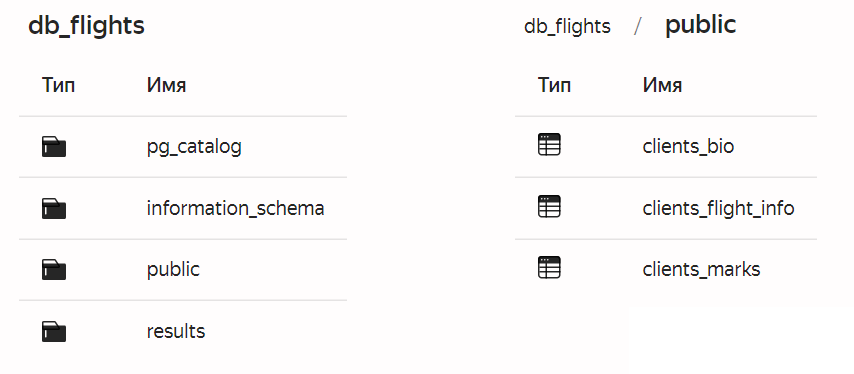

In [21]:
connection = psycopg2.connect(
    host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    port=6432,
    sslmode='verify-full',
    dbname='db_flights',
    user='mlhs_student',
    password='mlhs_student',
    target_session_attrs='read-write'
)

In [22]:
cursor = connection.cursor(cursor_factory = psycopg2.extras.RealDictCursor)

In [23]:
cursor.execute('''
SELECT
    *
FROM db_flights.public.clients_bio AS bio
INNER JOIN db_flights.public.clients_flight_info AS flight
ON bio.id = flight.id
INNER JOIN db_flights.public.clients_marks as marks
ON bio.id = marks.id
''')
result = cursor.fetchall()

In [24]:
cursor.close()
connection.close()

In [25]:
df = pd.DataFrame(result).set_index('id')

In [26]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [27]:
df_train = df[df.satisfaction != '-']

df_train.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [28]:
assert df_train.shape == (103_644, 23)

In [29]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0


In [30]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [31]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [32]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [33]:
X_train['satisfaction'] = y_train
X_val['satisfaction'] = y_val

#### 1.

In [34]:
import re

In [35]:
float_like = re.compile(r'\d+(\.\d+)?')
is_float = lambda x: True if x is None or float_like.fullmatch(x) else False

In [36]:
X_train.replace('nan', None, inplace=True)
X_val.replace('nan', None, inplace=True)

In [37]:
for column in X_train.columns:
  if X_train[column].apply(is_float).all():
    X_train[column] = X_train[column].apply(lambda x: float(x) if x is not None else None)
    X_val[column] = X_val[column].apply(lambda x: float(x) if x is not None else None)

In [38]:
X_train.isna().any(axis=0)

,0
gender,False
age,True
Customer Type,True
Type of Travel,True
class,True
Flight Distance,True
Departure Delay in Minutes,True
Arrival Delay in Minutes,True
Inflight wifi service,True
Departure/Arrival time convenient,True


In [39]:
X_num = X_train.select_dtypes('number')
iqr = X_num.quantile(0.75) - X_num.quantile(0.25)
((X_num > X_num.quantile(0.75) + 3 * iqr) | (X_num < X_num.quantile(0.25) - 3 * iqr)).any()

,0
age,True
Flight Distance,True
Departure Delay in Minutes,True
Arrival Delay in Minutes,True
Inflight wifi service,True
Departure/Arrival time convenient,True
Ease of Online booking,True
Gate location,True
Food and drink,True
Online boarding,True


In [40]:
X_str = X_train.select_dtypes('O')

In [41]:
from collections import Counter

def is_anomaly(col):
    count = Counter(col).most_common()
    anomalies = []
    i = len(count) - 1
    while i>= 0 and count[i][1] < len(col) * 5 / 100:
      anomalies.append(count[i][0])
      i -= 1

    return col.apply(lambda x: x in anomalies)

X_str.apply(is_anomaly, axis=1).any()

,0
gender,False
Customer Type,False
Type of Travel,False
class,False
satisfaction,False


#### 2.

In [42]:
filling = X_train.mode().T.to_dict()[0]
X_train.fillna(filling, inplace=True)
X_val.fillna(filling, inplace=True)

#### 3.

In [43]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000,72550.000000
mean,40.098856,1329.018332,15.859366,16.645968,2.733687,3.065017,2.761006,2.982688,3.209318,3.256513,3.445665,3.362150,3.383101,3.352364,3.630255,3.309056,3.640234,3.291178
std,20.658196,4764.369357,70.861937,97.990293,1.362172,1.552254,1.414843,1.316648,1.349963,1.372739,1.346077,1.360862,1.333758,1.360180,1.227853,1.293114,1.215114,1.343302
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,544.000000,379620.000000,9282.000000,11760.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


In [44]:
X_train.describe(include='O')

,gender,Customer Type,Type of Travel,class,satisfaction
count,72550,72550,72550,72550,72550
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,36816,59406,50054,34793,41083


In [45]:
X_train['class'].value_counts()

,count
class,
Business,34793
Eco,32546
Eco Plus,5211


#### 4.

- В числовых данных очень много аномалий (например, возраст 544 года или задержка в несколько дней, а также в оценках значения больше 5)
- В остальном числовые значения в рамках межквартильного размаха являются приемлемыми
- В категориальных значениях представлены ограниченные классы без каких-либо аномалий. В признаках `Customer Type` и `Type of Travel` наблюдается дисбаланс классов: наиболее популярные из двух классов охватывают 82% и 69% соответственно. Также самый маленький класс билетов, `Eco Plus`, составляет всего 7% от выборки

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

#### 1. Избавлюсь от неадекватных значений
Для начала избавлюсь от очевидных ошибок в данных: удалю строки, в которых значения оценок больше 5

In [46]:
marks = ['Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness']

In [47]:
X_train = X_train[(X_train[marks] <= 5).all(axis=1)]
X_val = X_val[(X_val[marks] <= 5).all(axis=1)]

Теперь рассмотрю возрастное распределение для того, чтобы понять пределы, в которых находятся реально встречающиеся значения

In [48]:
from matplotlib import pyplot as plt

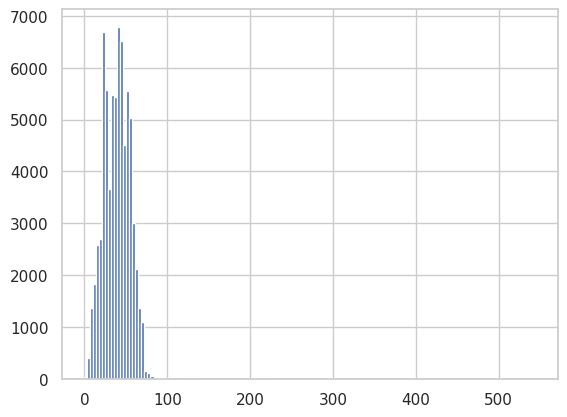

In [49]:
plt.figure()
plt.hist(X_train.age, bins=150)
plt.show()

По гистограмме видно, что основная часть значений находится где-то в промежутке от 0 до 100

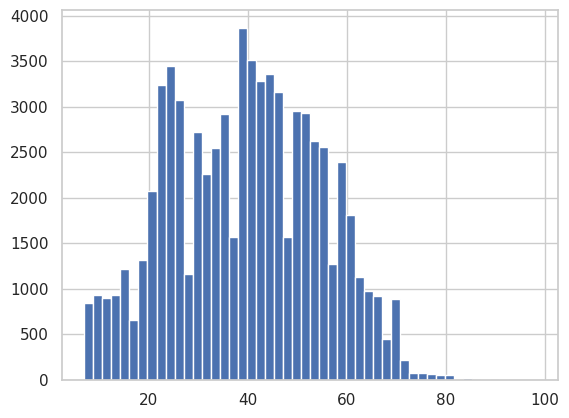

In [50]:
plt.figure()
plt.hist(X_train.age[(X_train.age > 0) & (X_train.age < 100)], bins=50)
plt.show()

Найду 0.005 и 0.995 квантили. Эти значения я буду считать адекватным промежутком, так как в него попадает 99% всех данных:

In [51]:
X_train.age.quantile(0.005), X_train.age.quantile(0.995)

(7.0, 78.0)

In [52]:
X_train = X_train[(X_train.age >= 7) & (X_train.age <= 78)]
X_val = X_val[(X_val.age >= 7) & (X_val.age <= 78)]

#### 2. Неочевидные аномалии
Теперь рассмотрю на предмет аномалий информацию о полете и задержках

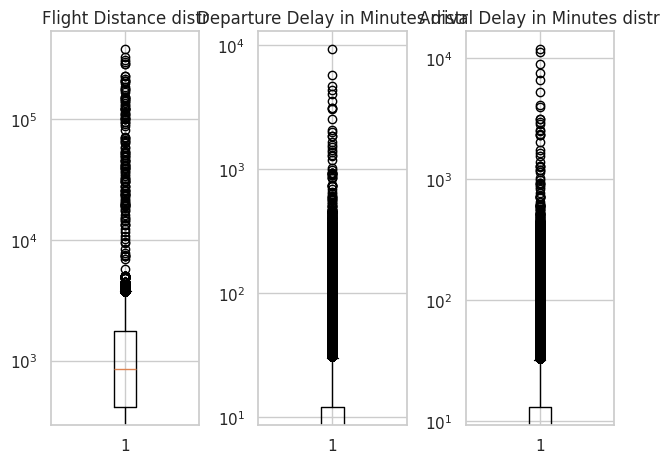

In [53]:
flight_info = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

fig, plots = plt.subplots(1, 3)
for i, feature in enumerate(flight_info):
  plots[i].boxplot(X_train[feature])
  plots[i].set_title(feature + ' distr')
  plots[i].set_yscale('log')
fig.tight_layout()
fig.show()

Здесь довольно сложно применить логику, поэтому просто отсеку данные, которые выходят за пределы $\mu ± (Q_3-Q_1)$:

In [54]:
Q1 = X_train[flight_info].quantile(0.25)
Q3 = X_train[flight_info].quantile(0.75)
iqr = Q3 - Q1

X_train = X_train[((X_train[flight_info] > Q1 - 3 * iqr) & (X_train[flight_info] < Q3 + 3 * iqr)).all(axis=1)]
X_val = X_val[((X_val[flight_info] > Q1 - 3 * iqr) & (X_val[flight_info] < Q3 + 3 * iqr)).all(axis=1)]

У `Flight Distance` оставлю значения, строго больше 0

In [55]:
X_train = X_train[X_train['Flight Distance'] > 0]
X_val = X_val[X_val['Flight Distance'] > 0]

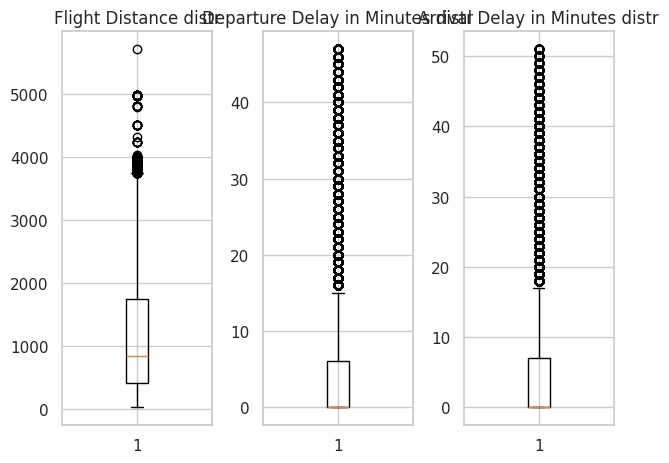

In [56]:
flight_info = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

fig, plots = plt.subplots(1, 3)
for i, feature in enumerate(flight_info):
  plots[i].boxplot(X_train[feature])
  plots[i].set_title(feature + ' distr')
fig.tight_layout()
fig.show()

#### 3. Закодирую категориальные переменные
Все категориальные переменные, кроме класса билета, бинарные, соответственно можно закодировать 0 и 1. Для деревьев это не имеет значения, поэтому пускай самый частый класс будет 0, иначе 1:

In [57]:
X_train.gender = X_train.gender.apply(lambda x: 0 if x == 'Female' else 1)
X_train['Customer Type'] = X_train['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
X_train['Type of Travel'] = X_train['Type of Travel'].apply(lambda x: 0 if x == 'Business travel' else 1)
X_train.satisfaction = X_train.satisfaction.apply(lambda x: 0 if x=='neutral or dissatisfied' else 1)

In [58]:
X_val.gender = X_val.gender.apply(lambda x: 0 if x == 'Female' else 1)
X_val['Customer Type'] = X_val['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
X_val['Type of Travel'] = X_val['Type of Travel'].apply(lambda x: 0 if x == 'Business travel' else 1)
X_val.satisfaction = X_val.satisfaction.apply(lambda x: 0 if x=='neutral or dissatisfied' else 1)

Пусть классы билетов будут идти по возрастанию стоимости: эконом, эконом плюс, бизнес:

In [59]:
X_train['class'] = X_train['class'].map({'Eco': 0, 'Eco Plus': 1, 'Business': 2})
X_val['class'] = X_val['class'].map({'Eco': 0, 'Eco Plus': 1, 'Business': 2})

#### 4. Изучу зависимости в данных

In [60]:
import seaborn as sns

<Axes: >

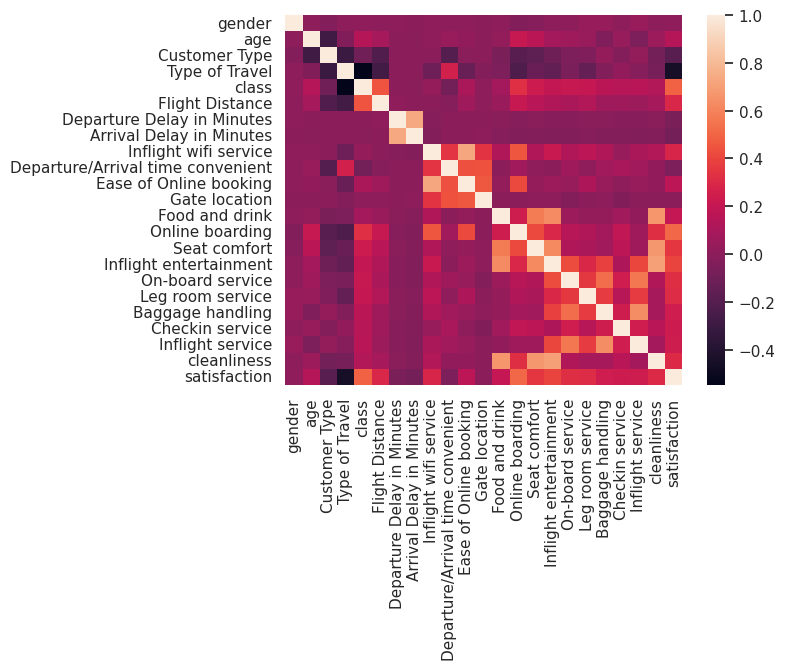

In [61]:
sns.heatmap(X_train.corr())

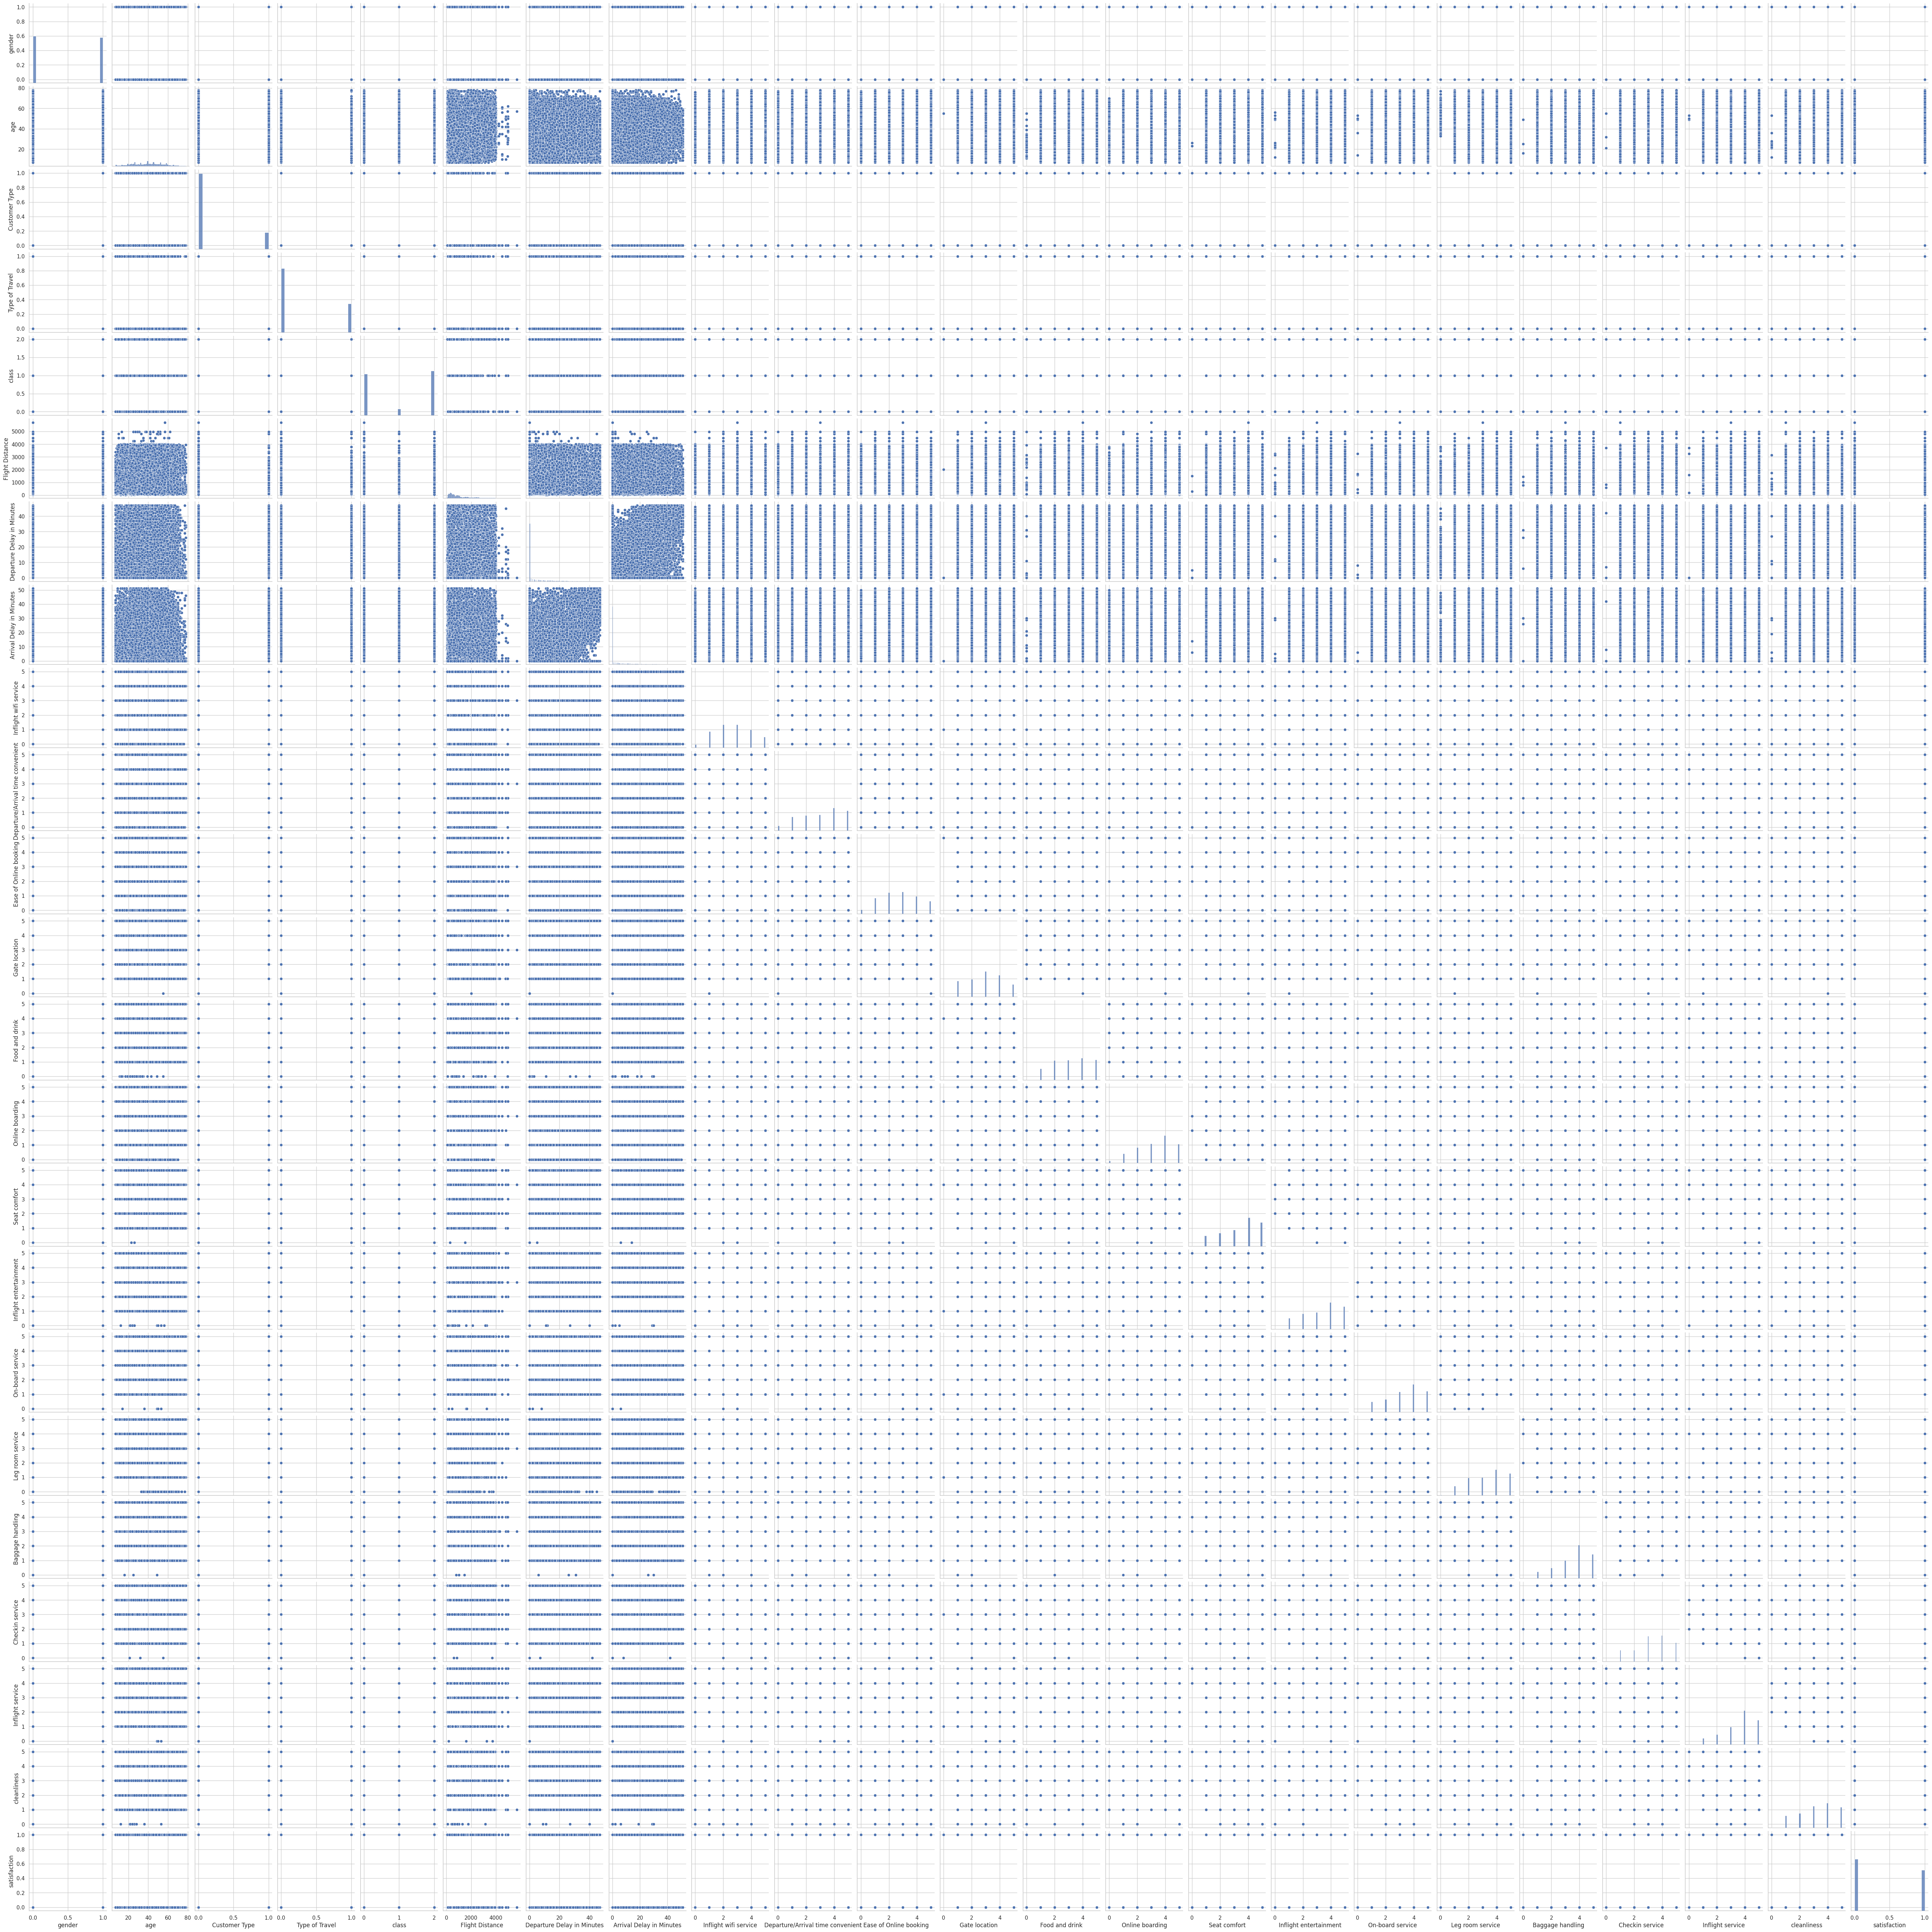

In [62]:
sns.pairplot(X_train)

Между собой скоррелированы некоторые оценки и время задержки. Так как во-певых, корреляция не такая сильная, а во-вторых, линейная зависимость параметров в данных не проблема для деревьев, оставлю их, как есть.<br>
Препроцессинг завершен

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [63]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [64]:
feature_types = ['categorical', 'real', 'categorical', 'categorical', 'categorical', 'real', 'real', 'real'] + (['categorical'] * 14)

In [65]:
y_train = X_train['satisfaction']
X_train = X_train.drop(columns='satisfaction')

y_val = X_val['satisfaction']
X_val = X_val.drop(columns='satisfaction')

In [66]:
dtree = DecisionTree(feature_types)
dtree.fit(X_train.to_numpy(), y_train.to_numpy())
pred = dtree.predict(X_val.to_numpy())
f1_score(y_val, pred)

0.9369177970256578

In [67]:
rforest = RandomForestClassifier()
rforest.fit(X_train, y_train)
pred = rforest.predict(X_val)
f1_score(y_val, pred)

0.9545985645134368

### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [68]:
# Ваш код здесь

### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

In [69]:
# Ваш код здесь

`Ваш ответ здесь. `

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [70]:
# Ваш код здесь

`Ваш ответ здесь. `

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [71]:
# Ваш код здесь

`Ваш ответ здесь. `

## Котобонус!

0.25 балла

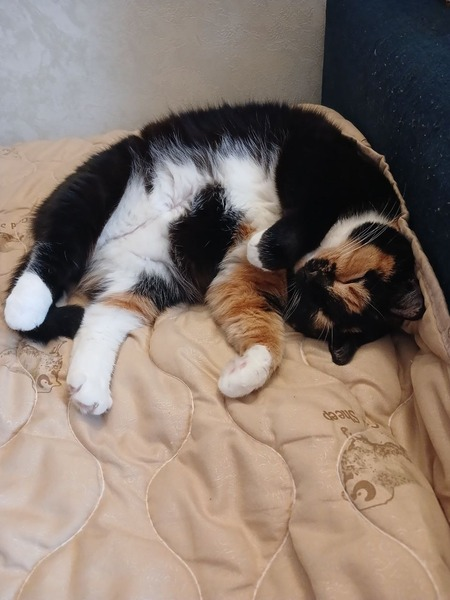

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

**Ответ:** У меня лично много времени ушло на первые части домашнего задания, а хотелось бы действительно познакомиться с интерпретацией важности признаков, потому что это неочевидная тема для деревьев